# **Rag From Scratch: Routing**

In [11]:
! pip install --upgrade --quiet langchain_community tiktoken langchain_groq langchain-huggingface langchainhub chromadb langchain youtube-transcript-api pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 6.5 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata
from uuid import uuid4

unique_id = uuid4()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["USER_AGENT"] = "myagent"

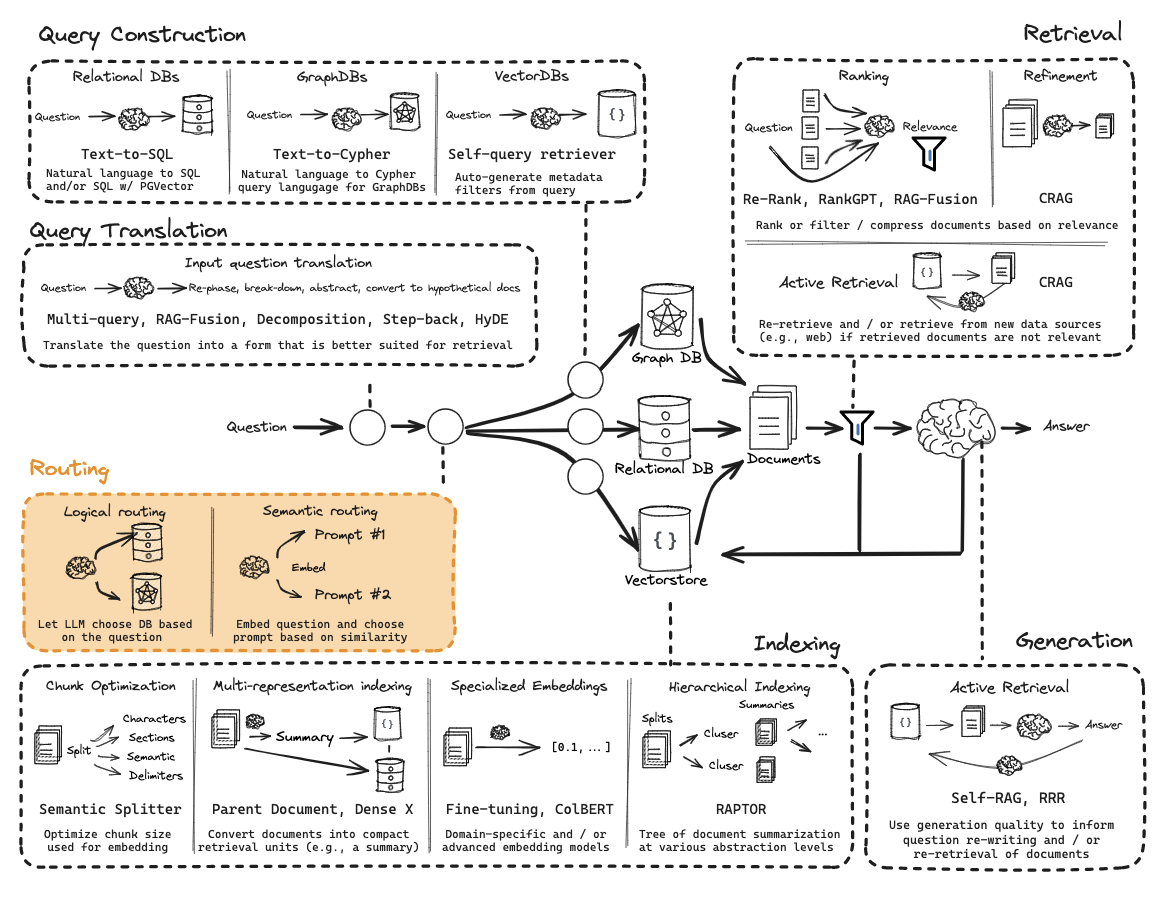

## Part 10: Logical and Semantic routing

### Logical routing

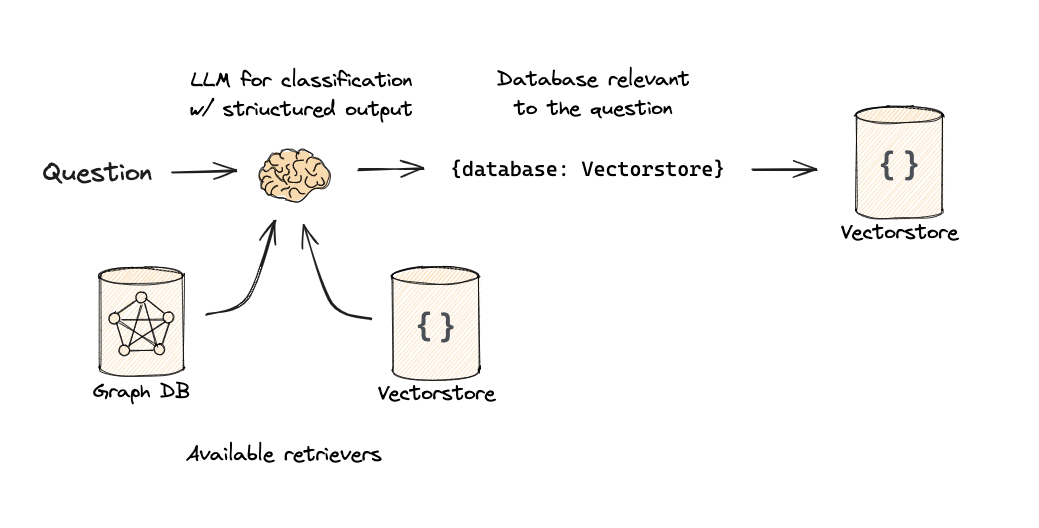

In [3]:
from typing import Literal

from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call
llm = ChatGroq(model="llama3-8b-8192", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router
router = prompt | structured_llm

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


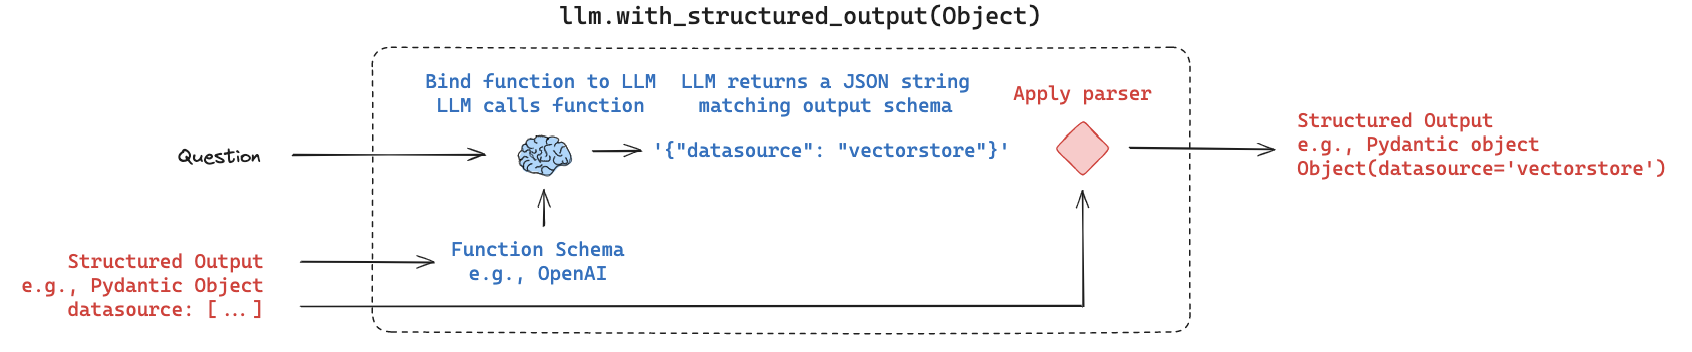

In [4]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [5]:
result

RouteQuery(datasource='python_docs')

In [6]:
result.datasource

'python_docs'

Once we have this, it is trivial to define a branch that uses `result.datasource`

https://python.langchain.com/docs/expression_language/how_to/routing

In [7]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here
        return "chain for js_docs"
    else:
        ### Logic here
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [8]:
full_chain.invoke({"question": question})

'chain for python_docs'

### Semantic routing

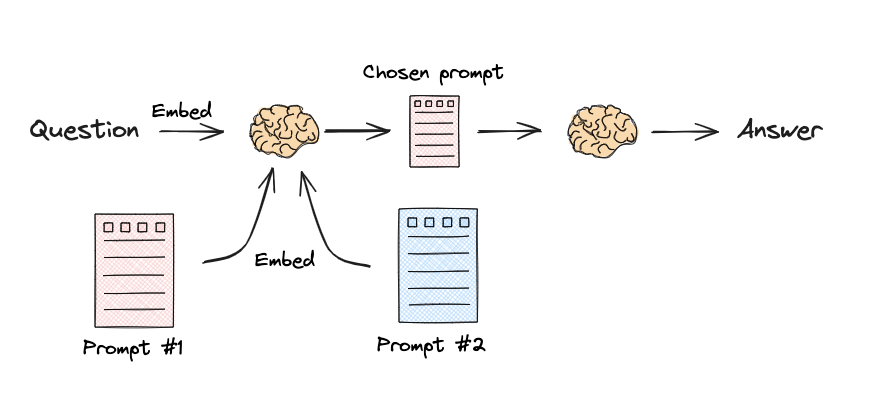

In [13]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_huggingface import HuggingFaceEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
from IPython.display import Markdown
Markdown(chain.invoke("What's a black hole"))

Using PHYSICS


Black holes! One of the most fascinating and mysterious phenomena in the universe.

A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape once it falls inside. It's formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it.

Imagine spacetime as a trampoline. When a massive object, like a star, sits on the trampoline, it creates a dent, or a curvature, in the surface. The more massive the object, the deeper the dent. Now, imagine what happens when that object collapses in on itself. The dent becomes so deep that it creates a hole, or a singularity, in the trampoline. That's essentially what a black hole is – a region of spacetime where the gravity is so strong that it creates a singularity.

Here's the really cool part: the point of singularity, called the event horizon, is the point of no return. Once something crosses the event horizon, it's trapped by the black hole's gravity and can never escape. That's why black holes are often referred to as "cosmic vacuum cleaners" – they suck in everything that gets too close, including stars, planets, and even light.

Now, I know some of you might be thinking, "But wait, if nothing can escape, then how do we know black holes exist?" Well, that's a great question! We know black holes exist because of the effects they have on the surrounding environment. For example, we can observe the motion of stars and gas near a suspected black hole, and we can even detect the radiation emitted by hot gas swirling around it. It's like trying to detect the presence of a monster in the dark by listening to the sounds it makes and feeling the vibrations it creates.

So, to summarize, a black hole is a region of spacetime where the gravity is so strong that nothing can escape, and it's formed when a massive star collapses in on itself. And, yes, I'm happy to admit that there's still much we don't know about black holes, but that's what makes them so fascinating, right?